# Import Library

In [1]:
import pandas as pd
import numpy as np
from progressbar import progressbar
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from statistics import mean

# Function Definition
## Visualization Function

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    fig, ax = plt.subplots(figsize=(10,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [3]:
def showClass(test_x, test_y):
    plt.figure(figsize=(17,5))
    for cls in range(10):
        for idx, sample in enumerate(test_x):
            if test_y[idx] == cls:    
                plt.subplot(1,10,cls+1)
                plt.axis("off") # 축 제거
                plt.imshow(sample)
                break
    plt.show()

## Binary transformation

In [4]:
def otsu_threshold(mat):
    hist = [0]*256
    for y in range(mat.shape[0]):
        for x in range(mat.shape[1]):
            hist[mat[y][x]] += 1
    max_benefit, threshold = float('inf'), 0

    for pivot in range(256):
        q1 = float(pivot) / 255.0
        q2 = 1 - q1
        m = np.mean(hist)
        benefit = q1 * np.mean((hist[:pivot] - np.mean(hist[:pivot])) ** 2) + q2 * np.mean((hist[pivot:] - np.mean(hist[pivot:])) ** 2)
        if max_benefit > benefit:
            max_benefit = benefit
            threshold = pivot
            
    res = np.zeros_like(mat)
    res[mat > threshold] = 1
    return res

## Morphological transformation

In [5]:
def erosion(img, kernel):
    origin_h, origin_w = kernel.shape
    org_y, org_x = int(origin_h/2), int(origin_w/2)
    h, w = img.shape
    result = np.zeros_like(img)

    for y in range(h):
        for x in range(w):
            if bool(img[y][x]):
                isFull = True
                try:
                    for h in range(y - org_y, y + org_y + 1):
                        for v in range(x - org_x, x + org_x + 1):
                            if not bool(img[h][v]):
                                isFull = False
                                break
                        if not isFull:
                            break
                except IndexError:
                    continue
                if isFull:
                    result[y][x] = 1
    return result

In [6]:
def dilation(img, kernel):
    origin_h, origin_w = kernel.shape
    org_y, org_x = int(origin_h/2), int(origin_w/2)
    h, w = img.shape
    result = np.zeros_like(img)

    for y in range(h):
        for x in range(w):
            if bool(img[y][x]):
                try:
                    for h in range(y - org_y, y + org_y + 1):
                        for v in range(x - org_x, x + org_x + 1):
                            result[h][v] = 1
                except IndexError:
                    continue
    return result

In [7]:
def opening(img, kernel):
    res1 = erosion(img, kernel)
    res2 = dilation(res1, kernel)
    return res2

def closing(img, kernel):
    res1 = dilation(img, kernel)
    res2 = erosion(res1, kernel)
    return res2

## Contour tracing

In [8]:
def contourTrace(img):
    def getNextContours(x, y, idirn):
        ring = [0] * 16
        ring[0] = img[y-1][x]
        ring[1] = img[y-1][x+1]
        ring[2] = img[y][x+1]
        ring[3] = img[y+1][x+1]
        ring[4] = img[y+1][x]
        ring[5] = img[y+1][x-1]
        ring[6] = img[y][x-1]
        ring[7] = img[y-1][x-1]
        for i in range(8):
            ring[i+8] = ring[i]

        i = (idirn + 5) % 8
        if i is 0:
            i = 8

        for j in range(8):
            i += 1
            if bool(ring[i]) and not bool(ring[i-1]):
                break

        idirn = i % 8

        if i % 8 == 1:
            x += 1
            y -= 1
        if i % 8 == 2:
            x += 1
        if i % 8 == 3:
            x += 1
            y += 1
        if i % 8 == 4:
            y += 1
        if i % 8 == 5:
            x -= 1
            y += 1
        if i % 8 == 6:
            x -= 1
        if i % 8 == 7:
            x -= 1
            y -= 1
        if i % 8 == 0:
            y -= 1
        return x, y, idirn

    height, width = img.shape
    cntList = []
    visit = np.zeros_like(img)
    for y in range(1, height - 1):
        for x in range(1, width - 1):
            if visit[y][x]:
                continue
            contours = []
            if bool(img[y][x]) and not bool(img[y][x-1]):
                idirn = 2
                contours.append([x, y])
                xStart = x
                yStart = y
                while True:
                    visit[y][x] = 1
                    x, y, idirn = getNextContours(x, y, idirn)
                    contours.append([x, y])
                    if x is xStart and y is yStart:
                        break
                cntList.append(contours)
    return cntList

## Dynamic Time Warping distance

In [9]:
def DTW_distance(A, B, window=99999999999, d=lambda x, y: abs(x - y)):
    # initialize cost matrix
    A, B = np.array(A), np.array(B)
    M, N = len(A), len(B)
    cost = 9999999999999 * np.ones((M, N))

    # fill first row, col
    cost[0, 0] = d(A[0], B[0])
    for i in range(1, M):
        cost[i, 0] = cost[i - 1, 0] + d(A[i], B[0])

    for j in range(1, N):
        cost[0, j] = cost[0, j - 1] + d(A[0], B[j])
    # fill last matrix
    for i in range(1, M):
        for j in range(max(1, i - window), min(N, i + window)):
            choices = cost[i - 1, j - 1], cost[i, j - 1], cost[i - 1, j]
            cost[i, j] = min(choices) + d(A[i], B[j])

    return cost[-1, -1]

# Data Analysis
## Train data

In [10]:
num_train = 100  # Number of data to train(to be search)
num_test = 50  # Number of data to test(to search)

# load train data
np.random.seed(1)  # seed
df_train = pd.read_csv("./data/train.csv")  # Loading Dataset
df_train = df_train.iloc[np.random.permutation(len(df_train))]  # Random permutaion

# train_x and train_y
train_x = np.asarray(df_train.iloc[:num_train, 1:]).reshape([-1, 28, 28]).astype(np.uint8)
train_y = np.asarray(df_train.iloc[:num_train, 0]).reshape([-1])

In [11]:
df_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
26247,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35067,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34590,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16668,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12196,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


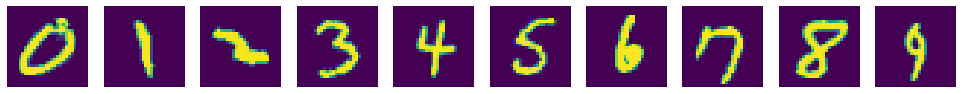

In [12]:
showClass(train_x, train_y)

In [13]:
df_test = pd.read_csv("./data/test.csv")
df_test = df_test.iloc[np.random.permutation(len(df_test))]  # Random permutaion
test_x = np.asarray(df_test.iloc[:num_test, 1:]).reshape([-1, 28, 28]).astype(np.uint8)
test_y = np.asarray(df_test.iloc[:num_test, 0]).reshape([-1])

## Test data

In [14]:
df_test.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
5656,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2937,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3855,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4226,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1149,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


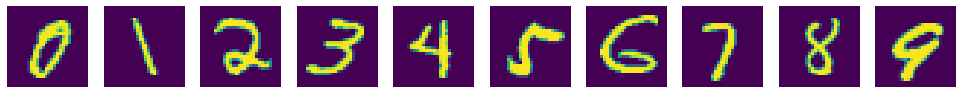

In [15]:
showClass(test_x, test_y)

# Image Transform
## Otsu threshold

C:\Users\moon_server\AppData\Local\Continuum\anaconda3\envs\py36env\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\moon_server\AppData\Local\Continuum\anaconda3\envs\py36env\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


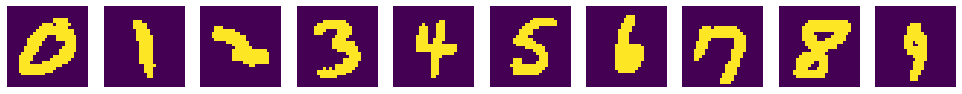

In [16]:
otsu_train_x = [otsu_threshold(sample) for sample in train_x]
otsu_test_x = [otsu_threshold(sample) for sample in test_x]
showClass(otsu_train_x, train_y)

## Closing operation

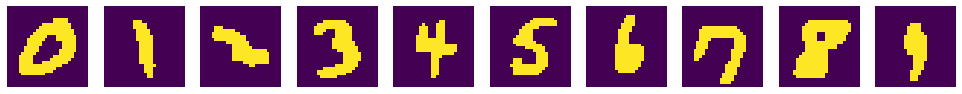

In [17]:
closing_train_x = [closing(sample, np.ones((3, 3), np.uint8)) for sample in otsu_train_x]
closing_test_x = [closing(sample, np.ones((3, 3), np.uint8)) for sample in otsu_test_x]
showClass(closing_train_x, train_y)

## Contours extraction

In [18]:
train_steps = []
for idx, sample in enumerate(closing_train_x):
    contours = contourTrace(sample)
    h_step = [point[0] for point in contours[np.argmax(len(cnt) for cnt in contours)]]
    v_step = [point[1] for point in contours[np.argmax(len(cnt) for cnt in contours)]]
    
    h_step = [(i-14)/28 for i in h_step]
    v_step = [(i-14)/28 for i in v_step]
     
    train_steps.append((h_step, v_step))

test_steps = []
for idx, sample in enumerate(closing_test_x):
    contours = contourTrace(sample)
    h_step = [point[0] for point in contours[np.argmax(len(cnt) for cnt in contours)]]
    v_step = [point[1] for point in contours[np.argmax(len(cnt) for cnt in contours)]]
    
    h_step = [(i-14)/28 for i in h_step]
    v_step = [(i-14)/28 for i in v_step]
    
    test_steps.append((h_step, v_step))

## Contours analysis of test data

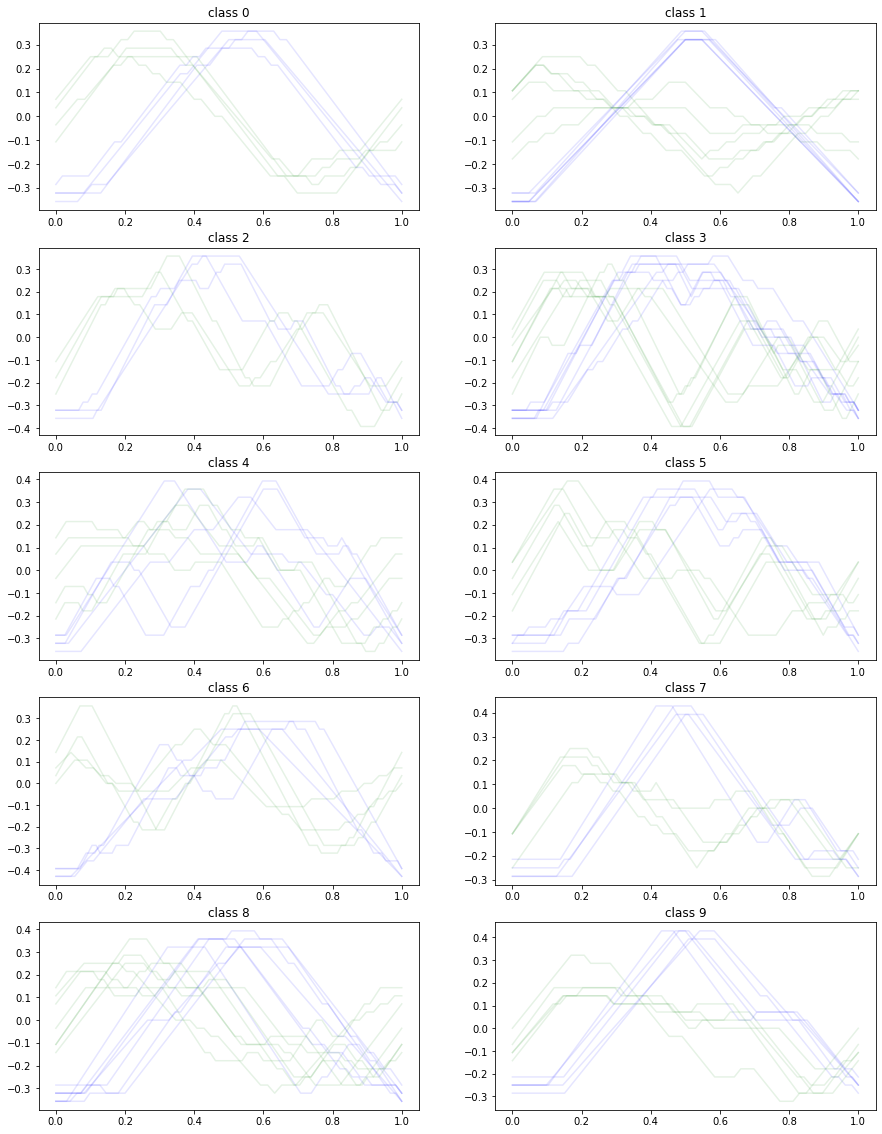

In [19]:
plt.figure(figsize=(15,20))
for cls in range(10):
    plt.subplot(5,2,cls+1)
    plt.title('class ' + str(cls))
    for idx, sample in enumerate(test_steps):
        if test_y[idx] == cls:    
            plt.plot(np.linspace(0,1,len(sample[0])), sample[0], color='green', alpha=0.1)
            plt.plot(np.linspace(0,1,len(sample[1])), sample[1], color='blue',  alpha=0.1)
plt.show()

## Contours analysis of train data

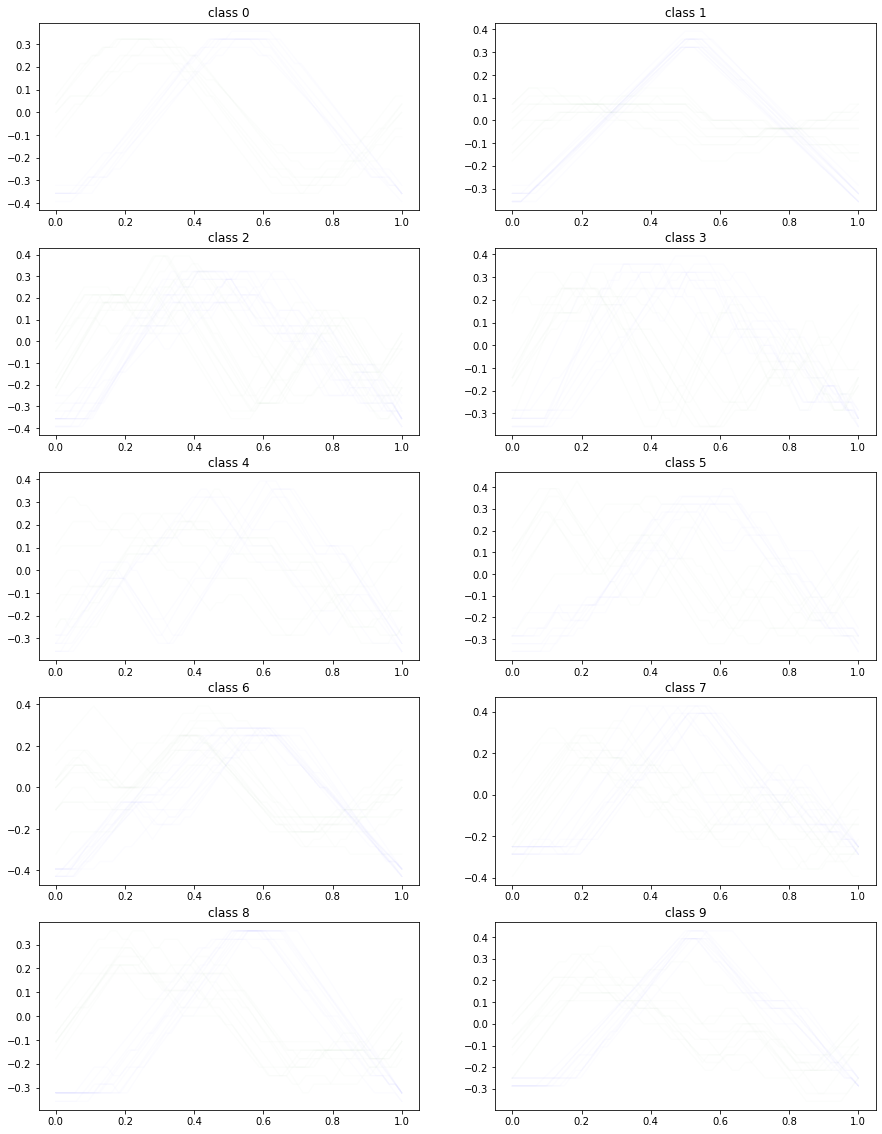

In [20]:
plt.figure(figsize=(15,20))
for cls in range(10):
    plt.subplot(5,2,cls+1)
    plt.title('class ' + str(cls))
    for idx, sample in enumerate(train_steps):
        if train_y[idx] == cls:    
            plt.plot(np.linspace(0,1,len(sample[0])), sample[0], color='green', alpha=0.01)
            plt.plot(np.linspace(0,1,len(sample[1])), sample[1], color='blue',  alpha=0.01)
plt.show()

# DTW Prediction

In [21]:
y_pred = np.zeros(len(test_y))
for idx, sample in enumerate(progressbar(test_steps)):
    minDist = float('inf')
    for step, cls in zip(train_steps, train_y):
        dist_x = DTW_distance(sample[0], step[0])
        dist_y = DTW_distance(sample[1], step[1])
        dist = sqrt(dist_x**2 + dist_y**2)
        if dist < minDist:
            minDist = dist
            y_pred[idx] = cls

100% (50 of 50) |########################| Elapsed Time: 0:00:55 Time:  0:00:55


In [22]:
# Accuracy
correct = 0
for idx in range(len(y_pred)):
    if test_y[idx] == y_pred[idx]:
        correct += 1
print("Correct/Total : {} / {}\nAccuracy : {}".format(correct, len(y_pred), correct/len(y_pred)))

Correct/Total : 28 / 50
Accuracy : 0.56


Confusion matrix, without normalization


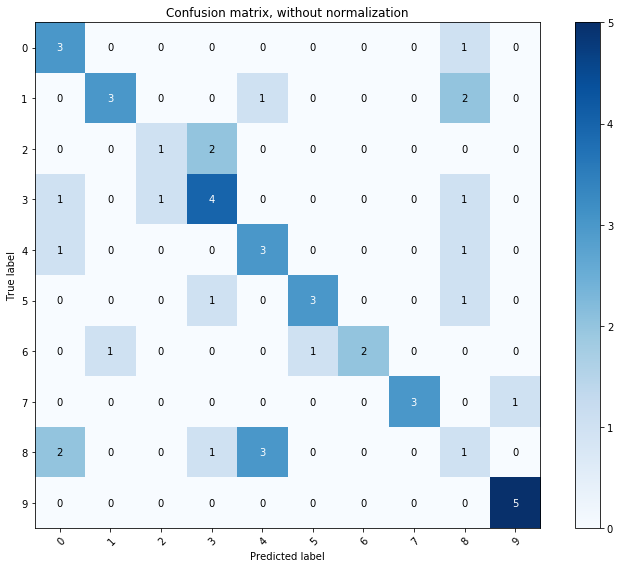

In [23]:
np.set_printoptions(precision=2)
class_names = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

# Plot non-normalized confusion matrix
plot_confusion_matrix(test_y, y_pred, classes=class_names, title='Confusion matrix, without normalization')
plt.show()